# Section 1

## First, Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd

## Split up dataset into training and testing

In [8]:
# Set transformation of data
transform = ToTensor()

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
download=True,
train=True,
transform=transform)

testset = torchvision.datasets.FashionMNIST('./data',
download=True,
train=False,
transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=30,
shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=30,
shuffle=False, num_workers=2)
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

## Visualize Data

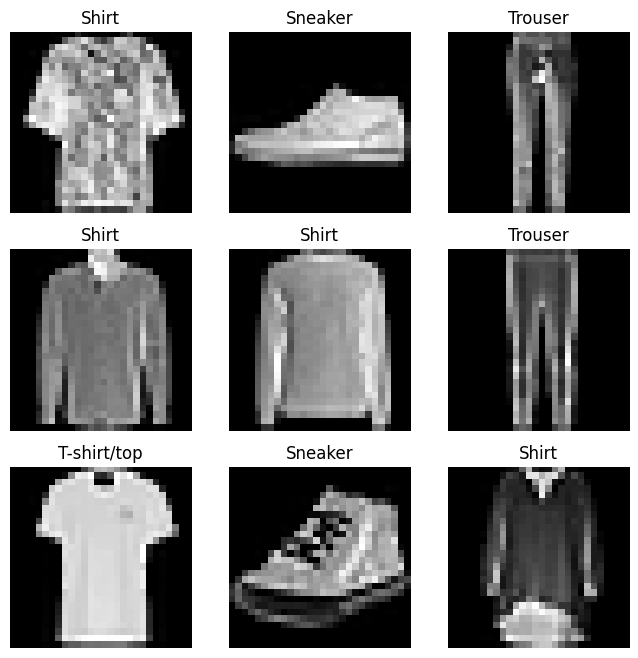

In [68]:


figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]   # img: [1, 28, 28]

    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(0), cmap="gray")

plt.show()


# Section 2

## Set Up Inital NN

In [69]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28 * 28, 1024)  # Input -> Hidden Layer
        self.fc2 = nn.Linear(1024, 10) # Hidden -> Ouput


    def forward(self, input):
        # Flatten image into a 784-dimensional vector
        input = torch.flatten(input, 1)

        # Apply first fully-connected layer and ReLU to produce hidden features (784 -> 1024)
        s1 = F.relu(self.fc1(input))
        
        # Apply output layer to map hidden features to class logits (1024 -> 10)
        output = self.fc2(s1)

        return output

        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


## Begin Training

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()          # clear old gradients
        outputs = net(images)         # forward pass
        loss = criterion(outputs, labels)  # compute cross entropy loss
        loss.backward()               # backprop
        optimizer.step()              # update weights

        running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

        


## Begin Evaluation Loop

In [71]:
correct = 0
total = 0

net.eval()
with torch.no_grad(): # Used to save memory since back propogation is not needed
    for images, labels in testloader:
        outputs = net(images) # Run through NN
        _, predicted = torch.max(outputs, 1) # Get confidence
        total += labels.size(0) # total pieces of data
        correct += (predicted == labels).sum().item() # how many correct

accuracy = 100 * correct / total # find accuracy
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 82.14%


## Train with 2 More Hidden Layers

### Add the 2 Layers and Update Forward Propogation

In [12]:
class Net2FC(nn.Module):
    
    def __init__(self, activation="relu"):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)

        if activation == "relu":
            self.act = F.relu
        elif activation == "sigmoid":
            self.act = torch.sigmoid
        else:
            raise ValueError("activation must be 'relu' or 'sigmoid'")


    def forward(self, input):
        # Flatten image into a 784-dimensional vector
        input = torch.flatten(input, 1)

        # Apply first fully-connected layer and ReLU to produce hidden features (784 -> 1024)
        s1 = self.act(self.fc1(input))
        # Send from first hidden layer to second hidden layer
        s2 = self.act(self.fc2(s1))
        # Apply output layer to map hidden features to class logits (1024 -> 10)
        output = self.fc3(s2)

        return output

net2FC = Net2FC()

### Begin Training

In [ ]:
for epoch in range(20):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()          # clear old gradients
        outputs = net(images)         # forward pass
        loss = criterion(outputs, labels)  # compute cross entropy loss
        loss.backward()               # backprop
        optimizer.step()              # update weights

        running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

### Begin Evaluation Loop

In [74]:
correct = 0
total = 0

net.eval()
with torch.no_grad(): # Used to save memory since back propogation is not needed
    for images, labels in testloader:
        outputs = net(images) # Run through NN
        _, predicted = torch.max(outputs, 1) # Get confidence
        total += labels.size(0) # total pieces of data
        correct += (predicted == labels).sum().item() # how many correct

accuracy = 100 * correct / total # find accuracy
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 84.01%


# Q2

Comparing the two outputs:

One hidden layer: 82.14%
Two hidden layers: 84.01%

This outputs to a 1.87% increase with the extra 1024 units in the hidden layer. 

Comparing the two architectures, the single hidden layer network achieved an accuracy of 82.14% while the two hidden layer network reached 84.01%, resulting in a 1.87% improvement when adding an additional 1024-unit hidden layer. This improvement is due to the increased depth, which allows the network to learn more complex and hierarchical feature representations by applying multiple nonlinear transformations, thereby increasing its expressive power and enabling better separation of classes in the learned feature space, which in turn leads to higher classification accuracy.

# Section 3

## Set Up Functions for Quicker Testing

In [6]:
def run_experiment(batch_size, lr, activation, epochs=20, num_workers=0):
    # Fresh model each time 
    net = Net2FC(activation=activation)

    # Fresh dataloaders each time 
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0)

    # Train
    print("beginning training")
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()          # clear old gradients
            outputs = net(images)         # forward pass
            loss = criterion(outputs, labels)  # compute cross entropy loss
            
            # If configuration diverges, stop early
            if not torch.isfinite(loss):
                return float("nan")

            loss.backward()               # backprop
            optimizer.step()              # update weights
            
            running_loss += loss.item()
        

        avg_loss = running_loss / len(trainloader)
    print(avg_loss)

    print("beginning eval loop")
    # Evaluate accuracy
    correct, total = 0, 0
    net.eval()
    with torch.no_grad(): # Used to save memory since back propogation is not needed
        for images, labels in testloader:
            outputs = net(images) # Run through NN
            _, predicted = torch.max(outputs, 1) # Get confidence
            total += labels.size(0) # total pieces of data
            correct += (predicted == labels).sum().item() # how many correct

    accuracy = 100.0 * correct / total
    return accuracy

## Test All 24 Cases

In [105]:
batch_sizes = [1, 10, 1000]
lrs = [1.0, 0.1, 0.01, 0.001]
activations = ["relu", "sigmoid"]

results = []

for bs in batch_sizes:
    for lr in lrs:
        for act in activations:
            acc = run_experiment(bs, lr, act, epochs=20)
            results.append({
                "batch_size": bs,
                "learning_rate": lr,
                "activation": act,
                "accuracy_%": round(acc, 2)
            })
            print(f"Done: bs={bs}, lr={lr}, act={act} -> {acc:.2f}%")

# using pandas, visualize the data
df = pd.DataFrame(results)
df = df.sort_values(["batch_size", "learning_rate", "activation"]).reset_index(drop=True)
print(df)

pivot = df.pivot_table(index=["batch_size", "learning_rate"], columns="activation", values="accuracy_%")
print(pivot)

beginning training
Done: bs=1, lr=1.0, act=relu -> nan%
beginning training
3.2103087789854654
Done: bs=1, lr=1.0, act=sigmoid -> 10.00%
beginning training
2.3255604332307973
Done: bs=1, lr=0.1, act=relu -> 10.00%
beginning training
0.21748760453263294
Done: bs=1, lr=0.1, act=sigmoid -> 88.07%
beginning training
0.16446039237330856
Done: bs=1, lr=0.01, act=relu -> 89.60%
beginning training
0.2828968308072646
Done: bs=1, lr=0.01, act=sigmoid -> 87.21%
beginning training
0.19357590536504482
Done: bs=1, lr=0.001, act=relu -> 88.66%
beginning training
0.41498039457601565
Done: bs=1, lr=0.001, act=sigmoid -> 82.57%
beginning training
2.326068779706955
Done: bs=10, lr=1.0, act=relu -> 10.00%
beginning training
0.2491776265553587
Done: bs=10, lr=1.0, act=sigmoid -> 86.90%
beginning training
0.165391554363814
Done: bs=10, lr=0.1, act=relu -> 89.61%
beginning training
0.283233346799243
Done: bs=10, lr=0.1, act=sigmoid -> 86.81%
beginning training
0.1924184600438166
Done: bs=10, lr=0.01, act=relu

# Q3

## Table of all 24 Cases

| Batch Size | Learning Rate | Avg ReLU Loss | ReLU Acc (%) | Avg Sigmoid Loss | Sigmoid Acc (%) |
| ---------- | ------------- | --------- | ------------ | ------------ | --------------- |
| 1          | 0.001         | 0.1936    | 88.66        | 0.4150       | 82.57           |
| 1          | 0.010         | 0.1645    | 89.60        | 0.2829       | 87.21           |
| 1          | 0.100         | 2.3256    | 10.00        | 0.2175       | 88.07           |
| 1          | 1.000         | NaN       | NaN          | 3.2103       | 10.00           |
| 10         | 0.001         | 0.3770    | 85.37        | 0.7211       | 74.16           |
| 10         | 0.010         | 0.1924    | 89.06        | 0.4167       | 83.61           |
| 10         | 0.100         | 0.1654    | 89.61        | 0.2832       | 86.81           |
| 10         | 1.000         | 2.3261    | 10.00        | 0.2492       | 86.90           |
| 1000       | 0.001         | 1.9901    | 58.79        | 2.2985       | 30.30           |
| 1000       | 0.010         | 0.6845    | 75.43        | 2.2325       | 28.36           |
| 1000       | 0.100         | 0.3871    | 84.34        | 0.7698       | 71.72           |
| 1000       | 1.000         | 1.3000    | 50.75        | 0.5399       | 78.45           |



### Best vs Worst Case

The best case recorded was: 10 batch size with 0.1 learning rate using ReLU as the loss function coming out to 89.61% accuracy for the model
The worst case recorded was: 1 batch size with 1.0 learning rate using ReLU as the loss function coming out to NaN, meaning the loss function came out to undefined/infinity, 
making the model unable to learn at all.

The best case corresponds to a moderate learning rate and appropriate batch size where the network converges and achieves close to 90% accuracy, 
meaning the model successfully learns meaningful patterns in the data and generalizes well beyond random guessing. In contrast, the worst case occurs when the learning rate is too large, 
causing gradient updates to raise far beyond the normal rate and the loss to become undefined, resulting in NaN accuracy; here, the optimization process itself breaks down and the model fails to learn anything at all. 

# Section 4

## Polluting the Training Set

In [10]:
# isolate polluted trainset
original_targets = trainset.targets
polluted_targets = original_targets.clone()

num_classes = 10

for c in range(num_classes):
    class_idx = torch.where(original_targets == c)[0]
    class_size = class_idx.numel()
    
    # 1% of class size
    k = int(0.01 * class_size)
    
    if k == 0:
        raise ValueError(f"Class {c} has too little samples")

    permutation = class_idx[torch.randperm(class_size, generator=torch.Generator().manual_seed(42))]
    
    #chose 9 sets of k images
    chosen = permutation[:9 * k] 
    
    # split into 9 equal groups
    groups = chosen.view(9, k)
    
    # build the list of remaining classes
    other_classes = [x for x in range(num_classes) if x != c]
    
    for i, new_class in enumerate(other_classes):
        polluted_targets[groups[i]] = new_class
    

clean_train_targets = trainset.targets.clone()
trainset.targets = polluted_targets

# Check changed labels
changed = (trainset.targets != clean_train_targets).sum().item()
total = len(trainset.targets)
print(f"Changed labels: {changed}/{total} ({100*changed/total:.2f}%)")




Changed labels: 5400/60000 (9.00%)


## Test on Training Set

In [114]:
# Train and Test Model with new Training Set
bs = 10
rl = 0.1
act = "relu"

acc = run_experiment(bs, lr, act, epochs=20)
print(f"Done: bs={bs}, lr={lr}, act={act} -> {acc:.2f}%")


beginning training
1.541146797299385
Done: bs=10, lr=0.1, act=relu -> 81.63%


# Q4

After polluting the training set, the accuracy dropped from 89.61% to 81.63%, a decrease of 7.92%. This occurs because pollution introduces incorrect labels into the training data, causing the model to learn misleading associations, such as interpreting sneakers as shirts or trousers as tops. Although only about 9% of the training samples were relabeled (1% from each class to each of the other classes), this label noise corrupts the learning signal and shifts the learned weights in inconsistent directions, which degrades the quality of the learned feature representations and decision boundaries, ultimately leading to a noticeable reduction in generalization performance on the clean test set.

# Section 5

## Get Clean Model

In [13]:
# Get clean Training Set
trainset.targets = clean_train_targets

# rebuild trainset loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=0)

# Train model on clean targets
net = Net2FC(activation="relu")

optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0)

criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()          # clear old gradients
        outputs = net(images)         # forward pass
        loss = criterion(outputs, labels)  # compute relu/cross entropy loss
        
        # If configuration diverges, stop early
        if not torch.isfinite(loss):
            print("NaN")
            break

        loss.backward()               # backprop
        optimizer.step()              # update weights
        
        running_loss += loss.item()
    

## Test Trained Model on Shifted Images

In [12]:
def evaluate_shifted(net, testloader, shift_right_px=2, shift_down_px=0):
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in testloader:
            if shift_right_px != 0:
                images = torch.roll(images, shifts=shift_right_px, dims=3)
            if shift_down_px != 0:
                images = torch.roll(images, shifts=shift_down_px, dims=2)

            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100.0 * correct / total

# 1) Shift right by 2
acc_right = evaluate_shifted(net, testloader, shift_right_px=2, shift_down_px=0)
print(f"Accuracy after right shift by 2 pixels: {acc_right:.2f}%")

# 2) Shift right by 2, then down by 2
acc_right_down = evaluate_shifted(net, testloader, shift_right_px=2, shift_down_px=2)
print(f"Accuracy after right+down shift by 2 pixels: {acc_right_down:.2f}%")


Accuracy after right shift by 2 pixels: 62.86%
Accuracy after right+down shift by 2 pixels: 52.45%


# Q5 

After circularly shifting each test image two pixels to the right, the classification accuracy dropped from the 89.61% value to 62.86%, a stunning drop by 26.75%. When the images were further shifted downward by two pixels on top of the original right shift, the accuracy decreased even more to 52.45% (-37.16%). This significant degradation shows that the fully connected network is highly sensitive to spatial translations, since shifting the pixels changes their positions in the flattened input vector and therefore alters the activations of the neurons. Proving even small spatial shifts can substantially disrupt its learned representations and lead to a large drop in performance when using a standard NN.

# Section 6

## Transform Image

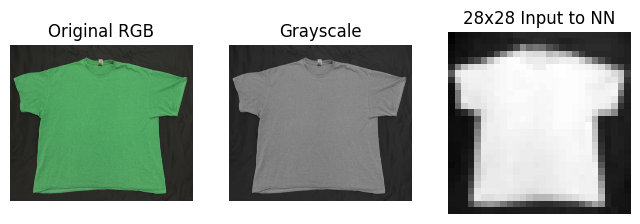

In [15]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("shirt-2.jpg")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

x = transform(img).unsqueeze(0)  # shape: [1, 1, 28, 28]
x = x.view(1, -1)               # shape: [1, 784]

# Original
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original RGB")
plt.axis("off")

# After grayscale
gray = transform.transforms[0](img)
plt.subplot(1,3,2)
plt.imshow(gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

# After full transform (28x28, normalized)
final = transform(img).squeeze().numpy()
plt.subplot(1,3,3)
plt.imshow(final, cmap="gray")
plt.title("28x28 Input to NN")
plt.axis("off")

plt.show()


## Run Image Through Model

In [14]:
with torch.no_grad():
    logits = net(x)
    probs = torch.softmax(logits, dim=1)

for cls, p in zip(classes, probs[0]):
    print(f"{cls:12s}: {p.item():.4f}")


T-shirt/top : 0.0000
Trouser     : 0.0000
Pullover    : 0.1132
Dress       : 0.0000
Coat        : 0.8783
Sandal      : 0.0083
Shirt       : 0.0000
Sneaker     : 0.0000
Bag         : 0.0002
Ankle Boot  : 0.0000
